In [2]:
from translation import FJSSPInstancesTranslator, SequenceGAEncoder
from model import ProductionEnvironment, Order
import pandas as pd

import re

In [3]:
lit_path = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\lit_results\lit_best_known.csv'
ga_path = r'C:\Users\huda\Downloads\final\final\\'
files = ['s0_s1_3600.txt','s4_3600.txt','s5_s6_s3_3600.txt', 's2a_3600.txt', 's2b_3600.txt', 's2c_s2d_3600.txt', 'behnke_geiger_repeat.txt', 'chambers.txt', 'dppaulli.txt', 'fattahi.txt', 'behnkegeiger.txt', 'brandimarte.txt', 'flexible_instances.txt']

gurobi_30 = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\gurobi_results\formatted_results\30_min.txt'
gurobi_60 = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\gurobi_results\formatted_results\60_min.txt'

benchmark_base_path = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\external_test_data\FJSSPinstances\\'

In [4]:
include_sdata = False

In [5]:
def generate_one_order_per_recipe(production_environment : ProductionEnvironment) -> list[Order]:
    orders : list[Order] = []
    for i in range(len(production_environment.resources.values())): # should be the same amount as recipes for now
        orders.append(Order(delivery_time=1000, latest_acceptable_time=1000, resources=[(production_environment.get_resource(i), 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0))
    return orders

In [6]:
def read_benchmark_file(source, instance):
    if source.startswith('0'):
        target_file = f'Behnke{instance}.fjs'
    elif source.startswith('1'):
        target_file = f'BrandimarteMk{instance}.fjs'
    elif source.startswith('2a'):
        target_file = f'HurinkSdata{instance}.fjs'
    elif source.startswith('2b'):
        target_file = f'HurinkEdata{instance}.fjs'
    elif source.startswith('2c'):
        target_file = f'HurinkRdata{instance}.fjs'
    elif source.startswith('2d'):
        target_file = f'HurinkVdata{instance}.fjs'
    elif source.startswith('3'):
        target_file = f'DPpaulli{instance}.fjs'
    elif source.startswith('4'):
        target_file = f'ChambersBarnes{instance}.fjs'
    elif source.startswith('5'):
        target_file = f'Kacem{instance}.fjs'
    elif source.startswith('6'):
        target_file = f'Fattahi{instance}.fjs'
    path = benchmark_base_path + f'{source}\\{target_file}'
    return open(path, 'r').readlines()

In [7]:
def load_benchmark_data(content = None, source = '', instance = 0):   
    line = dict()
    if content:
        line['source'] = content[0]
        line['instance'] = int(content[1])
    else:
        line['source'] = source
        line['instance'] = instance

    # add information about the benchmark instance
    benchmark_file = read_benchmark_file(line['source'], line['instance'])
    benchmark_system = benchmark_file[0].split(' ')
    line['n_machines'] = int(benchmark_system[1])
    line['n_jobs'] = int(benchmark_system[0])
    line['average_workstations_per_operation'] = float(benchmark_system[2])
    jobs = benchmark_file[1:]
    line['n_operations'] = sum([int(x.split(' ')[0]) for x in jobs])
    line['average_operations_per_job'] = line['n_operations'] / line['n_jobs']
    line['beta_flexibility'] = line['average_workstations_per_operation']/line['n_machines']
    line['approximate_max_dissimilarity'] = line['n_operations'] + line['average_operations_per_job'] * line['average_workstations_per_operation']

    production_environment = FJSSPInstancesTranslator().translate(line['source'], line['instance'])
    orders = generate_one_order_per_recipe(production_environment)
    production_environment.orders = orders
    workstations_per_operation, base_durations, job_operations = SequenceGAEncoder().encode(production_environment, orders)
    unique_durations = []
    overall_amount_durations = []
    for duration in base_durations:
        for d in duration:
            if d not in unique_durations and d > 0:
                unique_durations.append(d)
        overall_amount_durations.extend([x for x in duration if x > 0])
    overall_amount_durations = len(overall_amount_durations)
    line['duration_variety'] = (len(unique_durations)/overall_amount_durations)
    return line    

In [8]:
data = dict()
benchmark_data = []
for file in files:
    content = open(ga_path + file, 'r').readlines()
    for values in content:
        line = values.split(';')

        uid = line[0]+line[1]
        if include_sdata or not uid.startswith('2a'):
            if uid not in data:
                data[uid] = [float(line[6])]
            elif data[uid][0] > float(line[6]):
                data[uid] = [float(line[6])]

In [9]:
content = open(lit_path, 'r').readlines()
for values in content[1:]:
    line = values.split(';')
    uid = line[0]+line[1]
    #if not any([x['source'] == line[0] and x['instance'] == line[1] for x in benchmark_data]):
    benchmark_data.append(load_benchmark_data(line))
    if include_sdata or not uid.startswith('2a'):
        if uid in data: # skip remaining benchmarks
            value = float(line[3])
            if value < 0:
                value = 10000000 # replacing missing data
            data[uid].append(value)

In [10]:
content = open(gurobi_30, 'r').readlines()
for values in content[1:]:
    line = values.split(';')
    uid = line[0]+line[1]
    if include_sdata or not uid.startswith('2a'):
        if uid in data: # skip remaining benchmarks
            data[uid].append(int(float(line[2]) + 0.5))

In [11]:
content = open(gurobi_60, 'r').readlines()
for values in content[1:]:
    line = values.split(';')
    uid = line[0]+line[1]
    if include_sdata or not uid.startswith('2a'):
        if uid in data: # skip remaining benchmarks
            data[uid][2] = (int(float(line[2]) + 0.5)) # assuming 60 min is better than the 30 min result

In [12]:
def calc_gap(best, value):
    return (value - best)/best

In [13]:
example = '2a_Hurink_sdata29'
numbers = re.findall(r'\d+', example)
source = re.findall(r'[^\d+]', example)
print(numbers)
print(source)

['2', '29']
['a', '_', 'H', 'u', 'r', 'i', 'n', 'k', '_', 's', 'd', 'a', 't', 'a']


In [14]:
benchmarks = dict()
mapping = dict()
for key in data.keys():
    numbers = re.findall(r'\d+', key)
    rest = re.findall(r'[^\d+]', key)
    sId = int(numbers[0])
    source = ''
    if sId == 0:
        source = '0_BehnkeGeiger'
    elif sId == 1:
        source = '1_Brandimarte'
    elif sId == 2:
        if rest[0] == 'a':
            source = '2a_Hurink_sdata'
        elif rest[0] == 'b':
            source = '2b_Hurink_edata'
        elif rest[0] == 'c':
            source = '2c_Hurink_rdata'
        else:
            source = '2d_Hurink_vdata'
    elif sId == 3:
        source = '3_DPpaulli'
    elif sId == 4:
        source = '4_ChambersBarnes'
    elif sId == 5:
        source = '5_Kacem'
    else:
        source = '6_Fattahi'
    instance = int(numbers[1])
    benchmarks[key] = load_benchmark_data(source=source, instance=instance)
    mapping[key] = (source, instance)

In [15]:
# NOTE: 0 - GA, 1 - Lit, 2 - Gurobi
best = dict()
for key in data.keys():
    best[key] = min(data[key])
lit = dict()
for key in data.keys():
    lit[key] = data[key][1]
gaps_lit = dict()
for key in best.keys():
    gaps_lit[key] = dict()
    gaps_lit[key]['GA'] = (calc_gap(lit[key], data[key][0])) # GA
    #gaps_lit[key]['Literature'] = (calc_gap(lit[key], data[key][1])) # Lit
    gaps_lit[key]['Gurobi'] = (calc_gap(lit[key], data[key][2])) # Gurobi
gaps = dict()
for key in best.keys():
    gaps[key] = dict()
    gaps[key]['GA'] = (calc_gap(best[key], data[key][0])) # GA
    gaps[key]['Literature'] = (calc_gap(best[key], data[key][1])) # Lit
    gaps[key]['Gurobi'] = (calc_gap(best[key], data[key][2])) # Gurobi

In [16]:
data_for_df = []
for key in data.keys():
    data_for_df.append({
        'Source': mapping[key][0],
        'Instance': mapping[key][1],
        'GA': data[key][0],
        'Gurobi': data[key][2],
        'Literature': data[key][1],
        'GA Best Gap': gaps[key]['GA'],
        'Gurobi Best Gap': gaps[key]['Gurobi'],
        'Literature Best Gap': gaps[key]['Literature'],
        'GA Literature Gap': gaps_lit[key]['GA'],
        'Gurobi Literature Gap': gaps_lit[key]['Gurobi'],
        'GA/Gurobi': '+' if data[key][0] < data[key][2] else 'o' if data[key][0] == data[key][2] else '-',
        'GA/Literature': '+' if data[key][0] < data[key][1] else 'o' if data[key][0] == data[key][1] else '-',
        'n_machines': benchmarks[key]['n_machines'],
        'n_operations': benchmarks[key]['n_operations'],
        'beta_flexibility': benchmarks[key]['beta_flexibility'],
        'duration_variety': benchmarks[key]['duration_variety']
    })

In [17]:
df = pd.DataFrame(data_for_df)

In [18]:
df.to_csv('all_results.csv', sep=';')

In [19]:
df

,Source,Instance,GA,Gurobi,Literature,GA Best Gap,Gurobi Best Gap,Literature Best Gap,GA Literature Gap,Gurobi Literature Gap,GA/Gurobi,GA/Literature,n_machines,n_operations,beta_flexibility,duration_variety
0,1_Brandimarte,1,40.0,40,40.0,0.000000,0.000000,0.0,0.000000,0.000000,o,o,6,55,0.333333,0.052174
1,1_Brandimarte,2,26.0,27,26.0,0.000000,0.038462,0.0,0.000000,0.038462,+,o,6,58,0.583333,0.025210
2,1_Brandimarte,3,204.0,204,204.0,0.000000,0.000000,0.0,0.000000,0.000000,o,o,8,150,0.375000,0.037694
3,1_Brandimarte,4,60.0,60,60.0,0.000000,0.000000,0.0,0.000000,0.000000,o,o,8,90,0.250000,0.052326
4,1_Brandimarte,5,173.0,173,172.0,0.005814,0.005814,0.0,0.005814,0.005814,o,-,4,106,0.375000,0.027624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2d_Hurink_vdata,62,715.0,715,715.0,0.000000,0.000000,0.0,0.000000,0.000000,o,o,10,100,0.500000,0.131799
332,2d_Hurink_vdata,63,281.0,275,275.0,0.021818,0.000000,0.0,0.021818,0.000000,-,-,10,99,0.500000,0.084444
333,2d_Hurink_vdata,64,573.0,573,573.0,0.000000,0.000000,0.0,0.000000,0.000000,o,o,10,100,0.500000,0.134066
334,2d_Hurink_vdata,65,659.0,659,659.0,0.000000,0.000000,0.0,0.000000,0.000000,o,o,10,100,0.500000,0.147651


In [20]:
ga_lit_gaps = sorted([gaps_lit[key]['GA'] for key in gaps.keys()])
gurobi_lit_gaps = sorted([gaps_lit[key]['Gurobi'] for key in gaps.keys()])

In [21]:
print(ga_lit_gaps)

[-0.08333333333333333, -0.043233082706766915, -0.041121495327102804, -0.040892193308550186, -0.0399858457183298, -0.033962264150943396, -0.02824858757062147, -0.026217228464419477, -0.024, -0.023809523809523808, -0.023529411764705882, -0.023346303501945526, -0.022388059701492536, -0.01593625498007968, -0.011857707509881422, -0.01171875, -0.0111731843575419, -0.010826771653543307, -0.009345794392523364, -0.008264462809917356, -0.00819672131147541, -0.008064516129032258, -0.007722007722007722, -0.007575757575757576, -0.007532956685499058, -0.007352941176470588, -0.0016260162601626016, -0.001549186676994578, -0.000997406742469579, -0.00015344483658124905, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [22]:
def clean_source(source):
    if source.startswith('1'):
        return 'Brandimarte'
    elif source.startswith('0'):
        return 'BehnkeGeiger'
    elif source.startswith('2a'):
        return 'Hurink SData'
    elif source.startswith('2b'):
        return 'Hurink EData'
    elif source.startswith('2c'):
        return 'Hurink RData'
    elif source.startswith('2d'):
        return 'Hurink VData'
    elif source.startswith('3'):
        return 'DPpaulli'
    elif source.startswith('4'):
        return 'ChambersBarnes'
    elif source.startswith('5'):
        return 'Kacem'
    elif source.startswith('6'):
        return 'Fattahi'

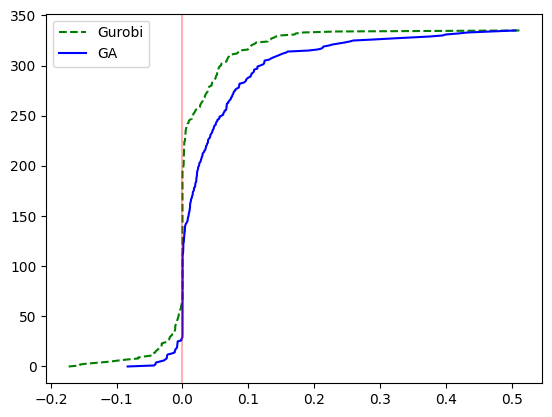

In [23]:
import matplotlib.pyplot as plt
import numpy as np
y = np.arange(len(ga_lit_gaps))
plt.plot(gurobi_lit_gaps, y, label='Gurobi', c='g', linestyle='dashed') #, marker='^', markersize=5, 
plt.plot(ga_lit_gaps, y, label='GA', c='b') #, marker='.', markersize=5
plt.axvline(0.0, c='r', alpha=0.3)
plt.legend()
plt.show()

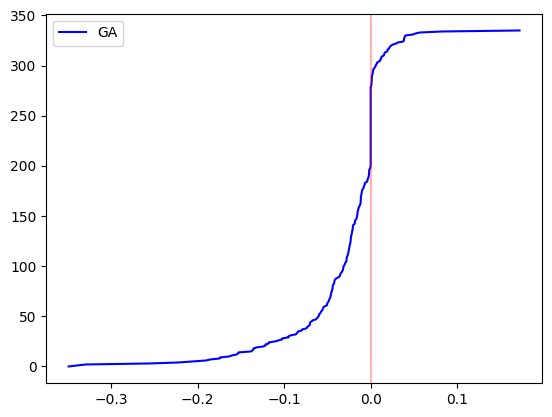

In [24]:
ga_gurobi_gaps = sorted([calc_gap(data[key][0], data[key][2]) for key in data.keys()])
import matplotlib.pyplot as plt
import numpy as np
y = np.arange(len(ga_gurobi_gaps))
plt.plot(ga_gurobi_gaps, y, label='GA', c='b') #, marker='.', markersize=5
plt.axvline(0.0, c='r', alpha=0.3)
plt.legend()
plt.show()


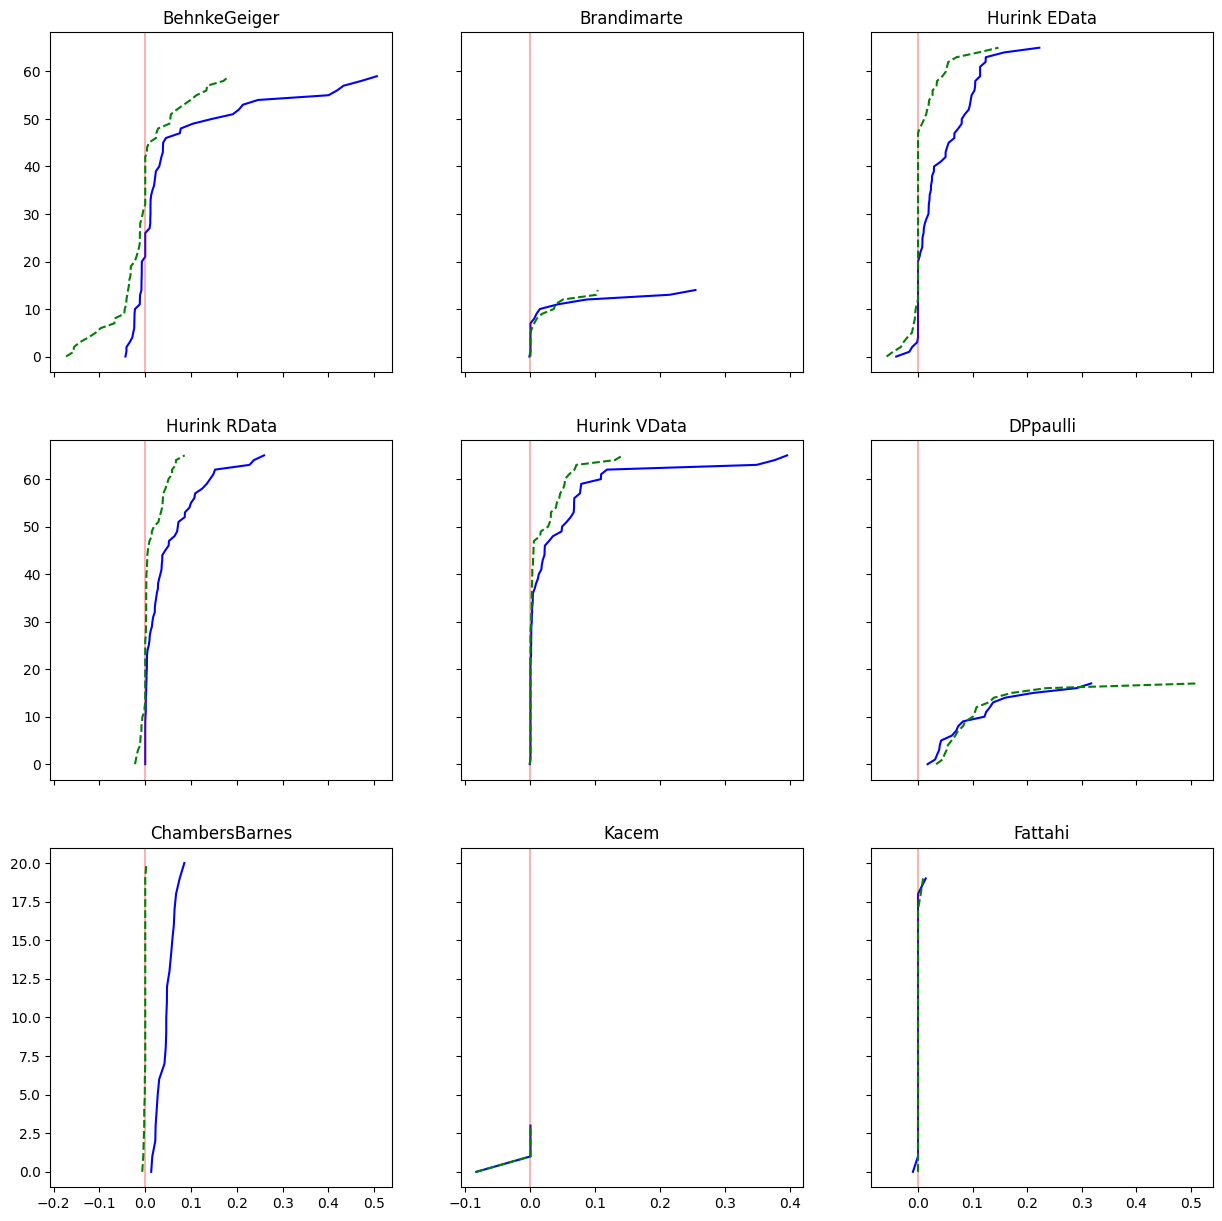

In [45]:
ga_lit_gaps_by_source = dict()
for entry in data.keys():
    lit_gap = calc_gap(data[entry][1], data[entry][0])
    source = mapping[entry][0]
    if source not in ga_lit_gaps_by_source:
        ga_lit_gaps_by_source[source] = []
    ga_lit_gaps_by_source[source].append(lit_gap)
gurobi_lit_gaps_by_source = dict()
for entry in data.keys():
    lit_gap = calc_gap(data[entry][1], data[entry][2])
    source = mapping[entry][0]
    if source not in gurobi_lit_gaps_by_source:
        gurobi_lit_gaps_by_source[source] = []
    gurobi_lit_gaps_by_source[source].append(lit_gap)
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, sharex='col', sharey='row')
fig.set_figwidth(15)
fig.set_figheight(15)
r_counter = 0
c_counter = 0
i = 0
sources = ['0_BehnkeGeiger', '1_Brandimarte', '2b_Hurink_edata', '2c_Hurink_rdata', '2d_Hurink_vdata', '3_DPpaulli', '4_ChambersBarnes', '5_Kacem', '6_Fattahi']
for row in range(rows):
    c_counter = 0
    for col in range(cols):
        source = sources[i]
        f = ax[r_counter][c_counter]
        x = sorted(ga_lit_gaps_by_source[source])
        y = np.arange(len(x))
        f.plot(x, y, label='GA', c='b')
        f.axvline(0.0, c='r', alpha=0.3)
        x = sorted(gurobi_lit_gaps_by_source[source])
        y = np.arange(len(x))
        f.plot(x, y, label='Gurobi', c='g', linestyle='dashed') #, marker='.', markersize=5
        f.set_title(clean_source(source))
        c_counter+=1
        i+=1
    r_counter+=1
"""for source in ga_lit_gaps_by_source.keys():
    x = sorted(ga_lit_gaps_by_source[source])
    y = np.arange(len(x))
    plt.plot(x, y, label='GA', c='b') #, marker='.', markersize=5
    plt.axvline(0.0, c='r', alpha=0.3)
    x = sorted(gurobi_lit_gaps_by_source[source])
    y = np.arange(len(x))
    plt.plot(x, y, label='Gurobi', c='g', linestyle='dashed') #, marker='.', markersize=5
    plt.title(clean_source(source))"""
plt.show()


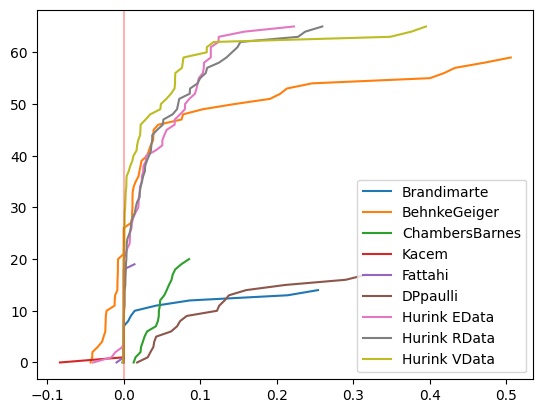

In [ ]:
ga_lit_gaps_by_source = dict()
for entry in data.keys():
    lit_gap = calc_gap(data[entry][1], data[entry][0])
    source = mapping[entry][0]
    if source not in ga_lit_gaps_by_source:
        ga_lit_gaps_by_source[source] = []
    ga_lit_gaps_by_source[source].append(lit_gap)
for source in ga_lit_gaps_by_source.keys():
    x = sorted(ga_lit_gaps_by_source[source])
    y = np.arange(len(x))
    plt.plot(x, y, label=clean_source(source)) #, marker='.', markersize=5
plt.axvline(0.0, c='r', alpha=0.3)
plt.legend()
plt.show()
